In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parent if Path.cwd().name == "examples" else Path.cwd()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")
print(f"Python path updated")

Project root: /home/datahub/Multi-Indicator-Machine-Learning-Trading-Strategy/notebooks
Python path updated


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.data.fetcher import get_single_ticker, get_vix, get_risk_free_rate
from src.data.features import FeatureEngineer, prepare_model_data

In [3]:
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
%matplotlib inline

In [4]:
#SPY is used as a liquid proxy for the US equity market allowing the analysis to focus on methodology rather than asset selection
TICKER = "SPY"
START_DATE = "2015-01-01"
END_DATE = "2024-01-01"

print(f"Analysing {TICKER} from {START_DATE} to {END_DATE}")

spy = get_single_ticker(TICKER, START_DATE, END_DATE)
print(f"Loaded {len(spy)} rows of price data")
print(spy.head())

vix = get_vix(START_DATE, END_DATE)
rf = get_risk_free_rate(START_DATE, END_DATE)

print(f"VIX data: {len(vix)} rows")
print(f"RF data: {len(rf)} rows")

Analysing SPY from 2015-01-01 to 2024-01-01
Attempting to load from cache...
Cached data doesn't cover requested period. Downloading...
Fetching data for SPY...
 Data for SPY cached at data/raw/SPY_1d.csv.
Loaded 2264 rows of price data
             adj_close       close        high         low        open  \
date                                                                     
2015-01-02  170.589615  205.429993  206.880005  204.179993  206.380005   
2015-01-05  167.508820  201.720001  204.369995  201.350006  204.169998   
2015-01-06  165.931107  199.820007  202.720001  198.860001  202.089996   
2015-01-07  167.998764  202.309998  202.720001  200.880005  201.419998   
2015-01-08  170.979889  205.899994  206.160004  203.990005  204.009995   

               volume  
date                   
2015-01-02  121465900  
2015-01-05  169632600  
2015-01-06  209151400  
2015-01-07  125346700  
2015-01-08  147217800  
Attempting to load from cache...
Cached data doesn't cover requested period.

In [5]:
#Feature are constructed using only information available at time t to prevent look-ahead bias in downstream modeling
engineer = FeatureEngineer()
features_df = engineer.create_all_features(spy, vix, rf)

print(f"\nCreated {len(features_df.columns)} columns")
print(f"Features: {len(engineer.get_feature_names(features_df))}")

Creating features...
Returns added
Momentum added
Volatility added
RSI added
Volume features added
VIX added
Risk-free rate added
Target created

Created 40 columns
Features: 32


In [6]:
#Explicit leakage diagnostics are run to detect features that may unintentionally encode future information
diagnostics = engineer.check_for_leakage(features_df)
print(f"Max correlation with target: {diagnostics['max_correlation']:.4f}")

if diagnostics["has_leakage"]:
    print("Warning : Potential data leakage detected in features:")
    print(diagnostics["suspicious_features"])
else:
    print("No data leakage detected.")

Max correlation with target: 0.0678
No data leakage detected.


In [7]:
print("\n" + "="*50)
print("Data quality")
print("="*50)

print("\n Missing values per column :")
missing = features_df.isna().sum()
missing_pct = (missing / len(features_df) * 100).round(2)
missing_df = pd.DataFrame({"missing_count": missing, "missing_pct": missing_pct})
missing_summary = missing_df[missing_df["missing_count"] > 0].sort_values("missing_count", ascending=False)
if len(missing_summary) > 0:
    print(missing_summary)
else:
    print("No missing values!")

print(f"\nDate range: {features_df.index.min()} to {features_df.index.max()}")
print(f"Total days: {len(features_df)}")

#Rows with missing values are dropped to ensure models are trained only on fully observable information
X, y_reg, y_clf = prepare_model_data(features_df, engineer, dropna=True)
print(f"\nClean data: {len(X)} samples ({len(X)/len(features_df)*100:.1f}% of original)")


Data quality

 Missing values per column :
                      missing_count  missing_pct
sigma_120d                      120         5.30
drift_120d                      120         5.30
vol_of_vol_60d                   79         3.49
drift_mean_reversion             60         2.65
drift_60d                        60         2.65
sigma_60d                        60         2.65
sigma_regime                     60         2.65
drift_vol_ratio_60d              60         2.65
ma_cross_20_50                   51         2.25
sma_50d                          50         2.21
price_to_sma_50                  50         2.21
vol_of_vol_20d                   39         1.72
volatility_20d                   21         0.93
return_20d                       21         0.93
log_return_20d                   21         0.93
price_to_sma_20                  20         0.88
sma_20d                          20         0.88
drift_20d                        20         0.88
drift_vol_ratio_20d      

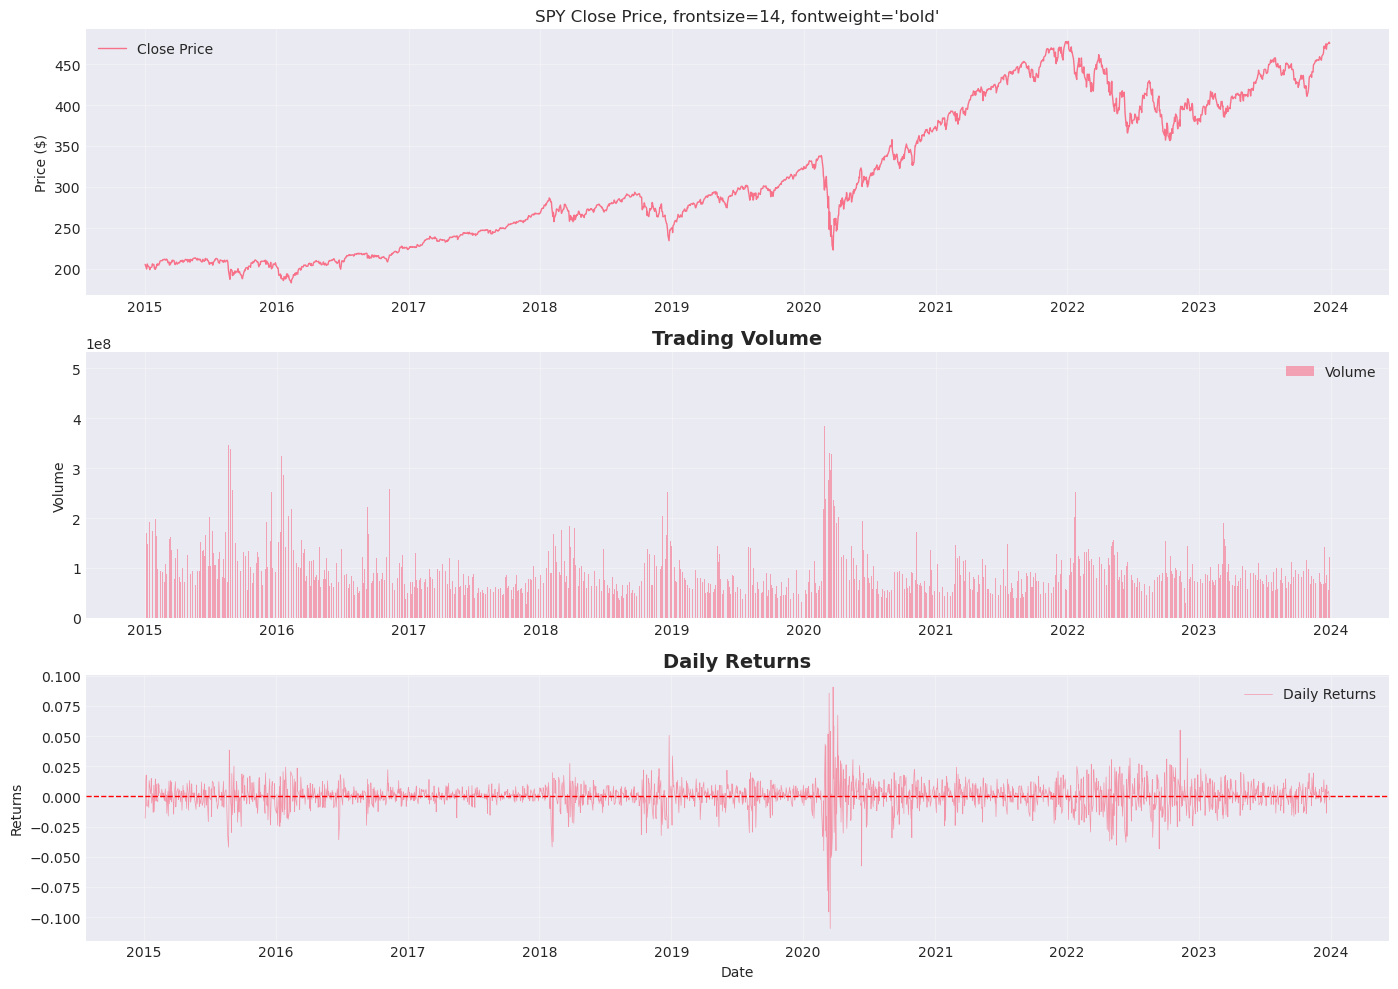

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

axes[0].plot(spy.index, spy["close"], label="Close Price", linewidth=1)
axes[0].set_title(f"{TICKER} Close Price, frontsize=14, fontweight='bold'")
axes[0].set_ylabel("Price ($)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].bar(spy.index, spy["volume"], alpha=0.6, label="Volume")
axes[1].set_title("Trading Volume", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Volume")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

returns = spy["close"].pct_change()
axes[2].plot(returns.index, returns, label="Daily Returns", linewidth=0.5, alpha=0.7)
axes[2].axhline(y=0, color="r", linestyle="--", linewidth=1)
axes[2].set_title("Daily Returns", fontsize=14, fontweight="bold")
axes[2].set_ylabel("Returns")
axes[2].set_xlabel("Date")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

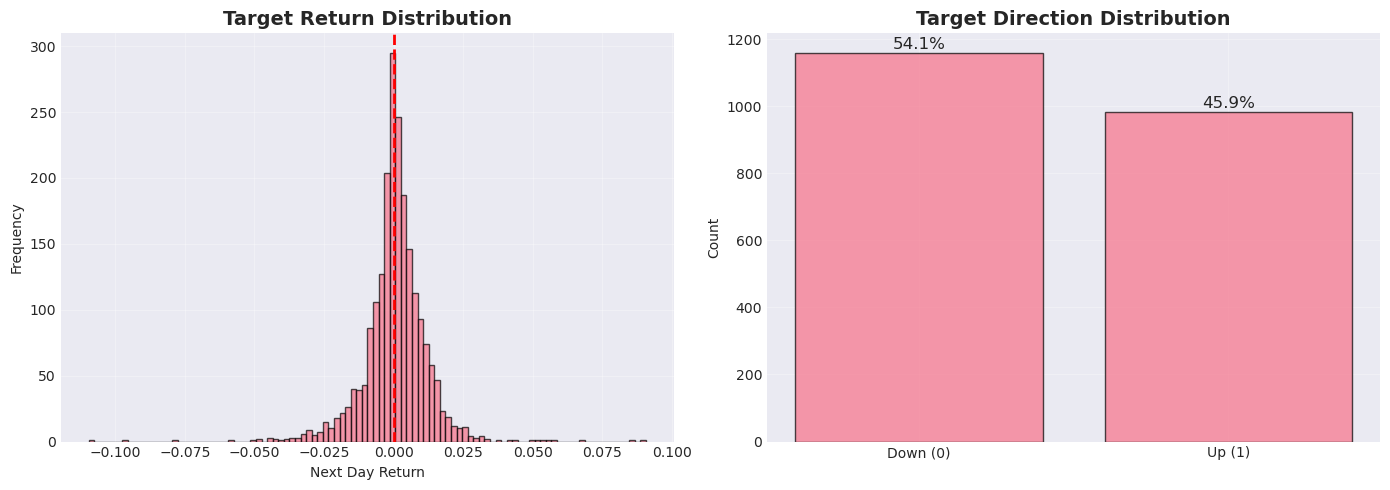


Target stats :
 Mean return : 0.0449%
Std return : 1.1634%
Up days : 1159 (54.1%)
Down days : 983 (45.9%)


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(y_reg, bins=100,alpha=0.7, edgecolor="black")
axes[0].axvline(x=0, color="r", linestyle="--", linewidth=2)
axes[0].set_title("Target Return Distribution", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Next Day Return")
axes[0].set_ylabel("Frequency")
axes[0].grid(True, alpha=0.3)

direction_counts = y_clf.value_counts()
axes[1].bar(["Down (0)", "Up (1)"], direction_counts.values, alpha=0.7, edgecolor="black")
axes[1].set_title("Target Direction Distribution", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Count")
axes[1].grid(True, alpha=0.3)

for i, v in enumerate(direction_counts.values):
    axes[1].text(i, v + 10, f"{v/len(y_clf) * 100:.1f}%", ha="center", fontsize=12)
plt.tight_layout()
plt.show()

print(f"\nTarget stats :")
print(f" Mean return : {y_reg.mean()*100:.4f}%")
print(f"Std return : {y_reg.std()*100:.4f}%")
print(f"Up days : {(y_clf==1).sum()} ({(y_clf==1).sum()/len(y_clf)*100:.1f}%)")
print(f"Down days : {(y_clf==0).sum()} ({(y_clf==0).sum()/len(y_clf)*100:.1f}%)")

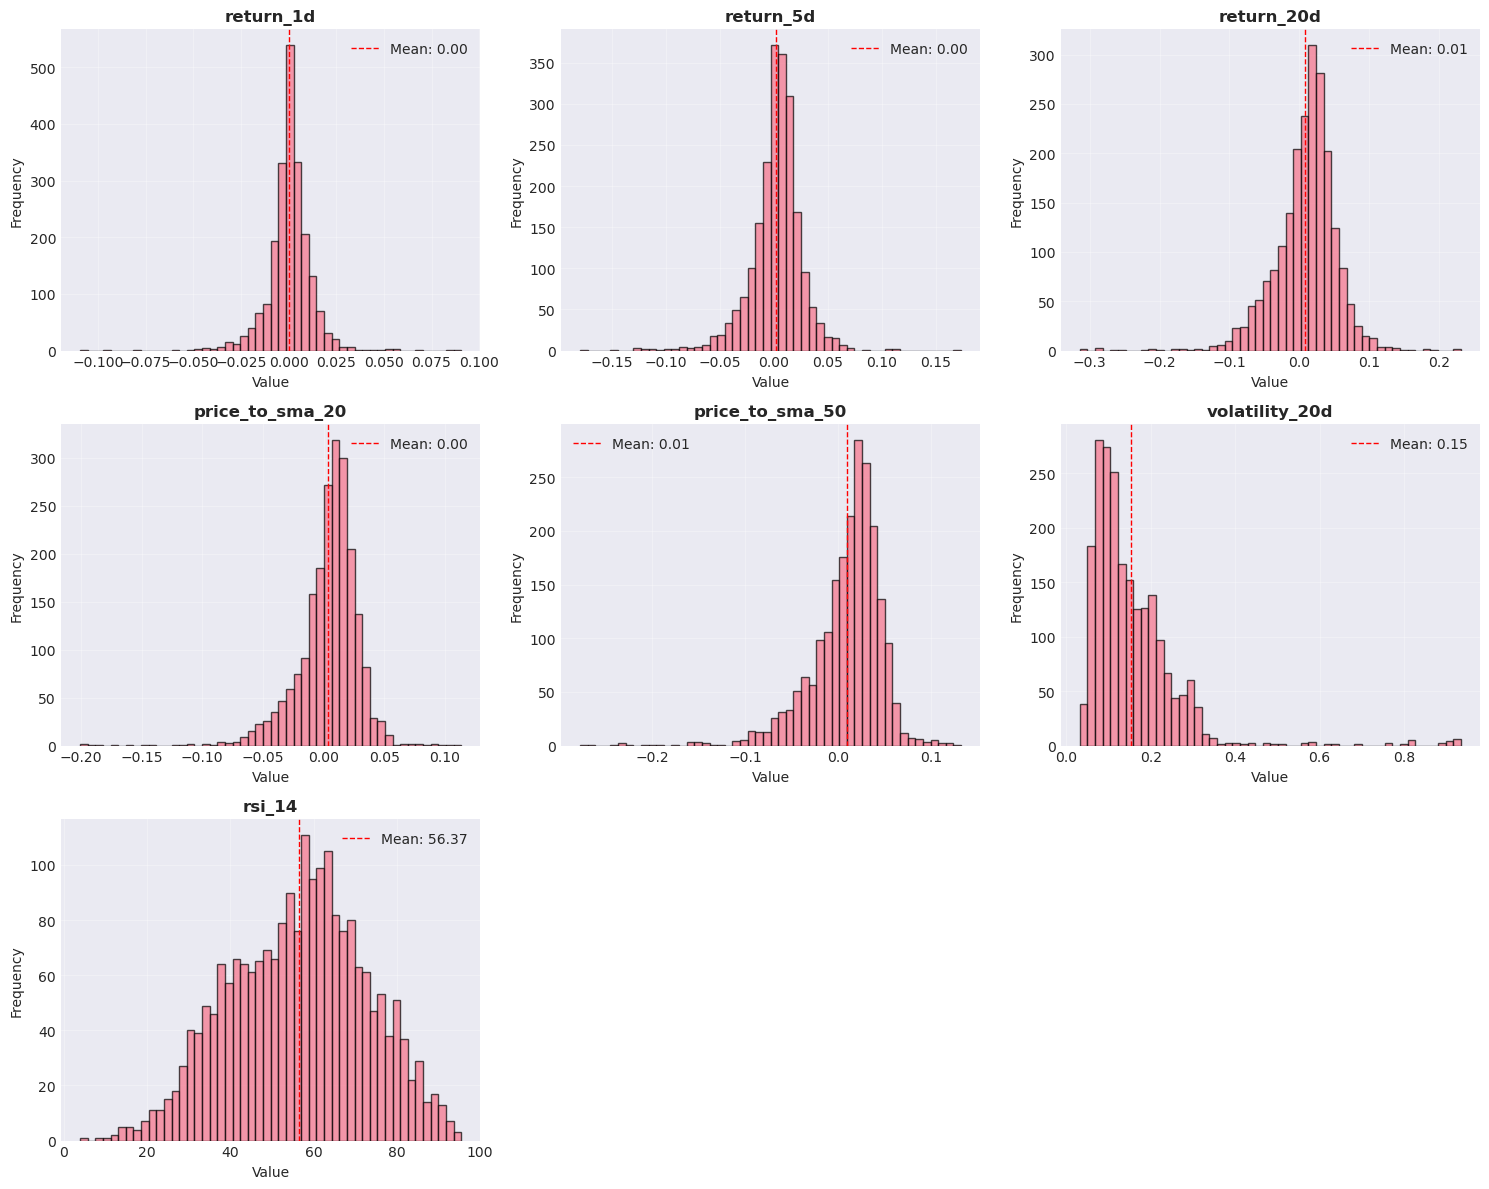

In [10]:
key_features = ["return_1d", "return_5d", "return_20d", "price_to_sma_20", "price_to_sma_50", "volatility_20d", "rsi_14"]

n_features = len(key_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(key_features):
    if feature in X.columns:
        X[feature].hist(bins=50, ax=axes[i], alpha=0.7, edgecolor="black")
        axes[i].set_title(feature, fontsize=12, fontweight="bold")
        axes[i].set_xlabel("Value")
        axes[i].set_ylabel("Frequency")
        axes[i].grid(True, alpha=0.3)

        mean_val = X[feature].mean()
        axes[i].axvline(x=mean_val, color="r", linestyle="--", linewidth=1, label=f"Mean: {mean_val:.2f}")
        axes[i].legend()

for i in range(n_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

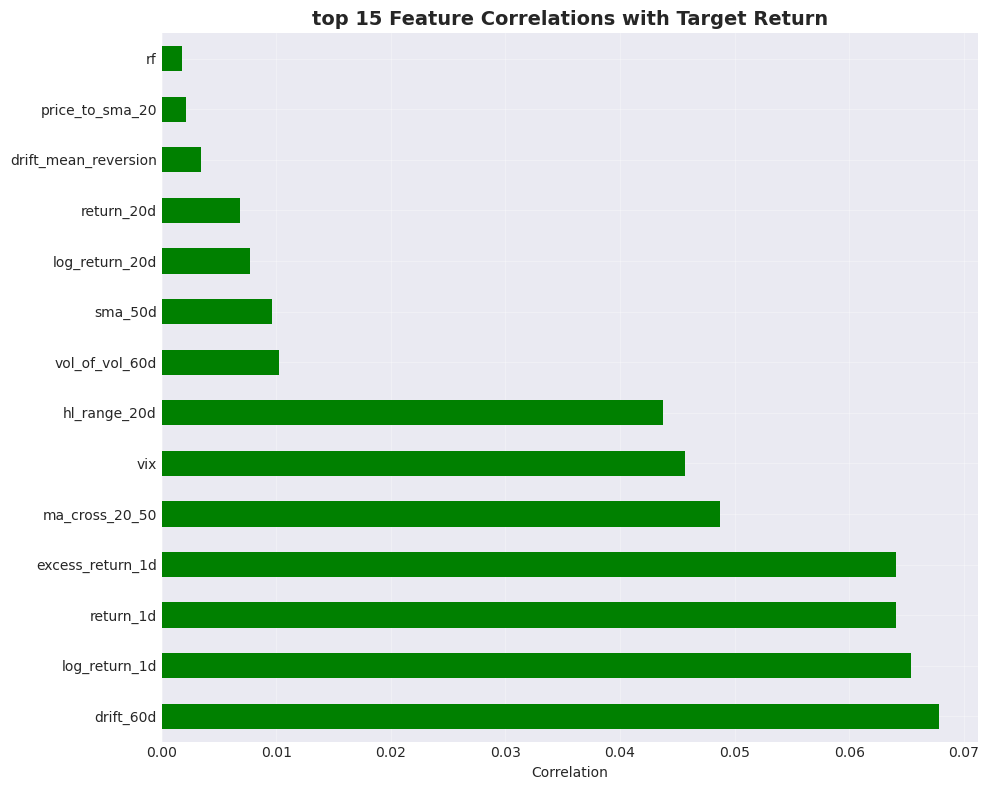


Top 10 positive correlations :
drift_60d           0.067832
log_return_1d       0.065357
return_1d           0.064111
excess_return_1d    0.064105
ma_cross_20_50      0.048682
vix                 0.045687
hl_range_20d        0.043718
drift_120d          0.043163
sigma_60d           0.042838
sigma_120d          0.040994
Name: target_return_1d, dtype: float64

Top 10 negative correlations :
vol_of_vol_20d          0.018069
sma_20d                 0.014463
sigma_regime            0.014273
vol_of_vol_60d          0.010195
sma_50d                 0.009658
log_return_20d          0.007716
return_20d              0.006815
drift_mean_reversion    0.003422
price_to_sma_20         0.002108
rf                      0.001808
Name: target_return_1d, dtype: float64


In [11]:
feature_names = engineer.get_feature_names(features_df)
correlations = features_df[feature_names + ["target_return_1d"]].corr()["target_return_1d"].drop("target_return_1d")
correlations = correlations.abs().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
top_n = 15
top_corr = pd.concat([correlations.head(top_n//2), correlations.tail(top_n//2)])
top_corr.plot(kind="barh", ax=ax, color=["green" if x > 0 else "red" for x in top_corr])
ax.set_title(f"top {top_n} Feature Correlations with Target Return", fontsize=14, fontweight="bold")
ax.set_xlabel("Correlation")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 10 positive correlations :")
print(correlations.head(10))
print("\nTop 10 negative correlations :")
print(correlations.tail(10))


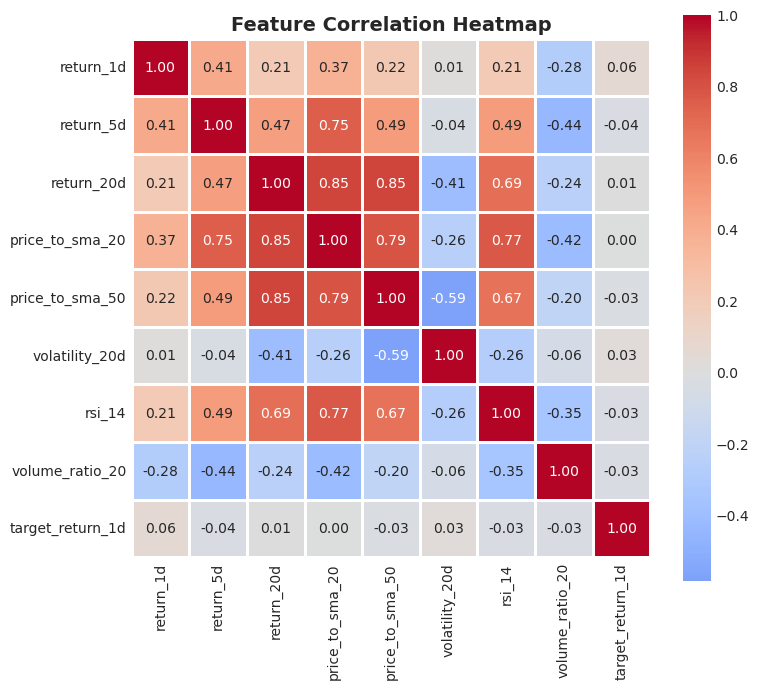

In [12]:
key_features_heatmap = ["return_1d", "return_5d", "return_20d", "price_to_sma_20", "price_to_sma_50", "volatility_20d", "rsi_14", "volume_ratio_20", "target_return_1d"]
corr_matrix = features_df[key_features_heatmap].corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title("Feature Correlation Heatmap", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [13]:
#Stationarity tests are performed to assess whether transformations (e.g. returns instead of prices) are statistically justified

from statsmodels.tsa.stattools import adfuller

print("\n" + "="*50)
print("Stationarity Tests (Augmented Dickey-Fuller)")
print("="*50)

def adf_test(series, name):
    """Perform adf test and print results"""
    results = adfuller(series.dropna())
    print(f"\n{name} :")
    print(f"ADF statistic : {results[0]:.4f}")
    print(f"p_value : {results[1]:.4f}")
    print(f"Critical Values :")
    for key, value in results[4].items():
        print(f"{key} : {value:.4f}")
    
    if results[1] < 0.05:
        print("Stationary (p < 0.05)")
    else:
        print("Non-Stationary (p >= 0.05)")
    
adf_test(spy["close"], "Price (Close)")
adf_test(features_df["return_1d"], "Returns (1d)")
adf_test(features_df["volatility_20d"], "Volatility (20d)")



Stationarity Tests (Augmented Dickey-Fuller)

Price (Close) :
ADF statistic : -0.4397
p_value : 0.9033
Critical Values :
1% : -3.4333
5% : -2.8628
10% : -2.5675
Non-Stationary (p >= 0.05)

Returns (1d) :
ADF statistic : -14.8819
p_value : 0.0000
Critical Values :
1% : -3.4333
5% : -2.8628
10% : -2.5675
Stationary (p < 0.05)

Volatility (20d) :
ADF statistic : -4.9564
p_value : 0.0000
Critical Values :
1% : -3.4333
5% : -2.8628
10% : -2.5675
Stationary (p < 0.05)



Returns by volatility regime
            count   mean    std  sharpe
vix_regime                             
Low Vol       869  0.037  0.524   1.119
Medium Vol   1043  0.029  1.009   0.463
High Vol      351  0.103  2.181   0.747


/tmp/ipykernel_4598/888576022.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  regime_stats = features_df.groupby("vix_regime")["target_return_1d"].agg([("count", "count"), ("mean", lambda x: x.mean()*100), ("std", lambda x: x.std()*100), ("sharpe", lambda x: x.mean() / x.std() * np.sqrt(252) if x.std() > 0 else 0)]).round(3)


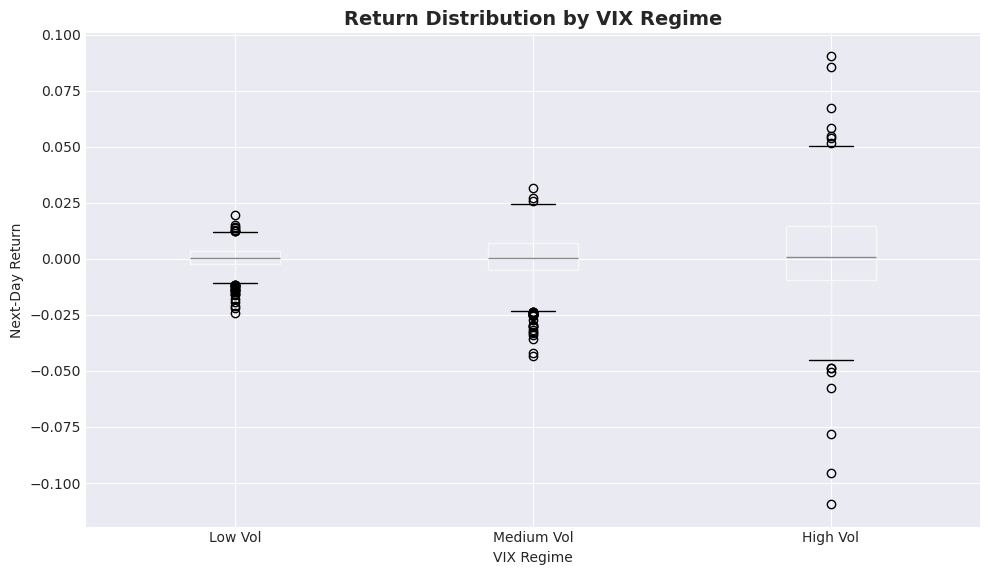

In [14]:
#Volatility regimes are defined using VIX thresholds to capture structurally different market environments

features_df["vix_regime"] = pd.cut(features_df["vix"], bins=[0, 15, 25, 100], labels=["Low Vol", "Medium Vol", "High Vol"])

regime_stats = features_df.groupby("vix_regime")["target_return_1d"].agg([("count", "count"), ("mean", lambda x: x.mean()*100), ("std", lambda x: x.std()*100), ("sharpe", lambda x: x.mean() / x.std() * np.sqrt(252) if x.std() > 0 else 0)]).round(3)

print("\n"+"="*50)
print("Returns by volatility regime")
print("="*50)
print(regime_stats)

fig, ax = plt.subplots(figsize=(10, 6))
features_df.boxplot(column="target_return_1d", by="vix_regime", ax=ax)
ax.set_title("Return Distribution by VIX Regime", fontsize=14, fontweight="bold")
ax.set_xlabel("VIX Regime")
ax.set_ylabel("Next-Day Return")
plt.suptitle("") 
plt.tight_layout()
plt.show()


In [15]:
print("\n" + "="*60)
print("Summary statistics - features")
print("="*60)
print(X.describe().T.round(4))


Summary statistics - features
                       count          mean           std           min  \
return_1d             2142.0  4.000000e-04  1.160000e-02 -1.094000e-01   
log_return_1d         2142.0  4.000000e-04  1.170000e-02 -1.159000e-01   
return_5d             2142.0  2.200000e-03  2.390000e-02 -1.797000e-01   
log_return_5d         2142.0  1.900000e-03  2.420000e-02 -1.981000e-01   
return_20d            2142.0  8.500000e-03  4.630000e-02 -3.139000e-01   
log_return_20d        2142.0  7.400000e-03  4.760000e-02 -3.767000e-01   
sma_20d               2142.0  3.165749e+02  8.484350e+01  1.883900e+02   
price_to_sma_20       2142.0  3.700000e-03  2.620000e-02 -2.008000e-01   
sma_50d               2142.0  3.148964e+02  8.420540e+01  1.931080e+02   
price_to_sma_50       2142.0  9.200000e-03  3.920000e-02 -2.782000e-01   
ma_cross_20_50        2142.0  5.300000e-03  2.430000e-02 -1.440000e-01   
volatility_20d        2142.0  1.535000e-01  1.044000e-01  3.190000e-02   
hl_rang